<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/ComparingNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/projects/project-notebooks/ComparingNetworks.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>



# Comparing networks

***Comparing networks: Characterizing computational similarity in task-trained recurrent neural networks***

**By Neuromatch Academy**


__Content creators:__ Chris Versteeg

__Content reviewers:__ Chris Versteeg, Hannah Choi, Eva Dyer

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk

---


## Section 5: Visualizing latent activity & applying PCA

Edited by DPAG for NeuroAI Project A

**INSTRUCTION IF RUNNING LOCALLY**:

Follow the instructions [here](https://github.com/snel-repo/ComputationThruDynamicsBenchmark) to setup the separate environment for this project, or you can run the cell below for general installment.

In [1]:
# Only needed once
# %pip install pickleshare

In [2]:
import contextlib
import io
import os

dirname = "ComputationThruDynamicsBenchmark"

with contextlib.redirect_stdout(io.StringIO()):  # to suppress output
    if not os.path.isdir(dirname):
        ! git clone https://github.com/neuromatch/ComputationThruDynamicsBenchmark
        %cd ComputationThruDynamicsBenchmark
        ! pip install -e .

envStr = """HOME_DIR=ComputationThruDynamicsBenchmark/

# Don't change these
TRAIN_INPUT_FILE=train_input.h5
EVAL_INPUT_FILE=eval_input.h5
EVAL_TARGET_FILE=eval_target.h5
"""

with open('.env', 'w') as f:
    f.write(envStr)

The Computation-Thru-Dynamics Benchmark has three distinct behavioral tasks.

These tasks are called:
1. Three-Bit Flip-Flop (3BFF) (see [Sussillo & Barak 2013](https://pubmed.ncbi.nlm.nih.gov/23272922/))
2. MultiTask (See [Driscoll et al. 2023](https://www.biorxiv.org/content/10.1101/2022.08.15.503870v1.full.pdf))
3. RandomTarget (See [Codol et al. 2023](https://elifesciences.org/reviewed-preprints/88591v2/reviews))

We chose these tasks because they represent a variety of task complexities. We have a pretty good understanding of how the simpler tasks operate (3BFF), but really are only starting to scratch the surface of more complex tasks (RandomTarget).

Specificially, in the Random Target task, the actions that the model takes can affect the future inputs, making it an important test case for being able to understand the dynamics of interacting systems!

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/TaskComplexity-01.png?raw=true" width="600"/>

Each task (which we call a "task environment") follows a standardized format that allows alternative task environments to be incorporated without any changes to the training pipeline.

Here, we'll take a walk through the two tasks in the project template (TBFF and RandomTarget) and inspect the behavior of networks trained in these environments.

In [3]:
# set the random seed for reproducibility
import random
import dotenv
import pathlib
import os
import logging

# comment the next three lines if you want to see all training logs
pl_loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict if 'pytorch_lightning' in name]
for pl_log in pl_loggers:
    logging.getLogger(pl_log.name).setLevel(logging.WARNING)

random.seed(2024)

dotenv.load_dotenv(override=True)
HOME_DIR = os.getenv("HOME_DIR")
if HOME_DIR is None:
    HOME_DIR = ""
print(HOME_DIR)

ComputationThruDynamicsBenchmark/


Now, we use `pickle` to save the trained model and datamodule for future analyses!

❓❓❓

**Once you get this model trained, feel free to try changing the hyperparameters to see if you can get the model to train faster!**

❓❓❓

In [4]:
from ctd.task_modeling.model.node import NODE
from ctd.task_modeling.model.rnn import GRU_RNN
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
import pathlib, pickle, torch, sys

# Make the NODE put hidden on the input’s device 
class NODE_CUDA(NODE):
    def forward(self, inputs, hidden):
        if hidden is None:
            hidden = torch.zeros((inputs.shape[0], self.latent_size),
                                 device=inputs.device)
        else:
            hidden = hidden.to(inputs.device)
        hidden = self.generator(inputs, hidden)
        return self.readout(hidden), hidden

In [5]:
import os 

MODEL_DIR = "C:/Users/blxck/Desktop/NeuroMatch25/ComputationThruDynamicsBenchmark/MODELS/"

models = {}
for subdir_name in os.listdir(MODEL_DIR):
    subdir_path = os.path.join(MODEL_DIR, subdir_name)
    
    if os.path.isdir(subdir_path):
        model_path = os.path.join(subdir_path, "model.pkl")
        
        if os.path.exists(model_path):
            with open(model_path, "rb") as f:
                try:
                    model = pickle.load(f)
                    models[subdir_name] = model
                    print(f"✅ Loaded model: {subdir_name}")
                except Exception as e:
                    print(f"❌ Failed to load {model_path}: {e}")


✅ Loaded model: 3BFF-NODE
✅ Loaded model: 3BFF-RNN
✅ Loaded model: 4BFF-NODE
✅ Loaded model: 4BFF-RNN


## Section 5: Inspecting the performance of trained models

Now that the models have been trained, let's see if we can determine how similar their computational strategies are to each other!

To make your life easier, we've provided an "analysis" object that abstracts away much of the data handling, allowing you to work more easily with the data from the models.

The analysis object also offers visualization tools that can help to see how well the trained model learned to perform the task!

For example, plot_trial_io is a function that plots (for a specified number of trials):
- Latent activity
- Controlled output
- Target output
- Noisy inputs to model

❓❓❓

**Try changing trials that are plotted. Do the models capture all of the states equally well?**

❓❓❓

### Part 1: Visualizing latent activity

In [6]:
# For next part to run, DSA needs to be installed 
# !git clone https://github.com/mitchellostrow/DSA
# %cd DSA/
# !pip install -e .

In [7]:
# LOADING 3BFF RNN MODEL

sys.path.append(r"C:\Users\blxck\Desktop\NeuroMatch25\ComputationThruDynamicsBenchmark\DSA")

from ctd.comparison.analysis.tt.tt import Analysis_TT

# Path to specific model folder
model_3BFF_RNN_path = MODEL_DIR + "3BFF-RNN/"

# Create the analysis object
analysis_3BFF_RNN = Analysis_TT(
    run_name="3BFF-RNN",
    filepath=model_3BFF_RNN_path)

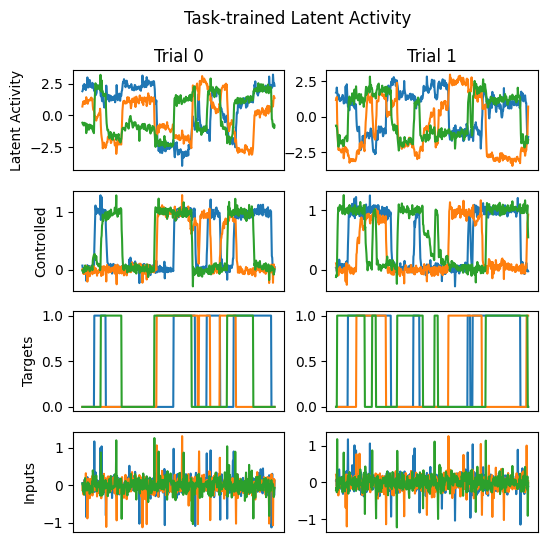

In [8]:
analysis_3BFF_RNN.plot_trial_io(num_trials = 2)

In [9]:
# LOADING 3BFF NODE MODEL

# # Path to specific model folder
model_3BFF_NODE_path = MODEL_DIR + "3BFF-NODE/"

# Create the analysis object
analysis_3BFF_NODE = Analysis_TT(
    run_name="3BFF-NODE",
    filepath=model_3BFF_NODE_path)

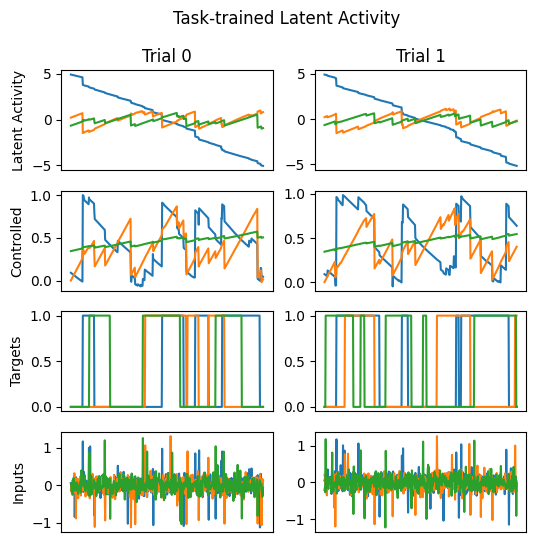

In [10]:
analysis_3BFF_NODE.plot_trial_io(num_trials = 2)

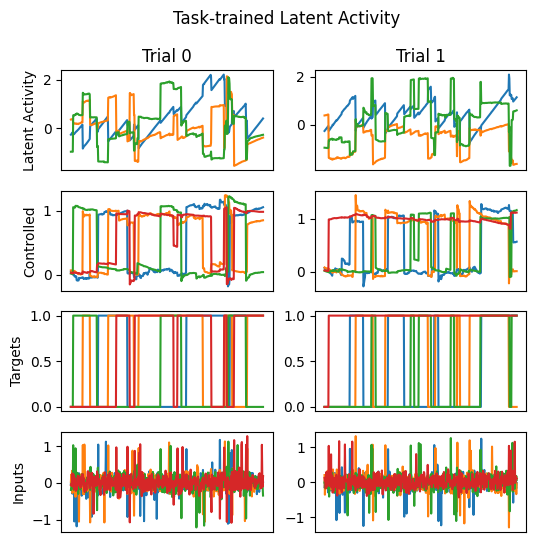

In [11]:
# LOADING 4BFF NODE MODEL

# # Path to specific model folder
model_4BFF_NODE_path = MODEL_DIR + "4BFF-NODE/"

# Create the analysis object
analysis_4BFF_NODE = Analysis_TT(
    run_name="4BFF-NODE",
    filepath=model_4BFF_NODE_path)

analysis_4BFF_NODE.plot_trial_io(num_trials = 2)

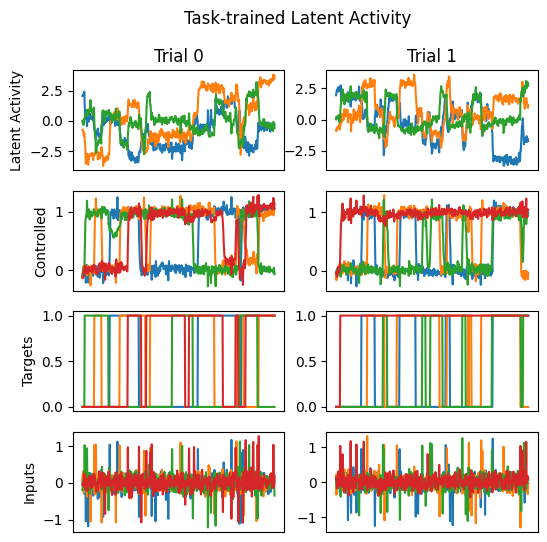

In [12]:
# LOADING 4BFF RNN MODEL

# # Path to specific model folder
model_4BFF_RNN_path = MODEL_DIR + "4BFF-RNN/"

# Create the analysis object
analysis_4BFF_RNN = Analysis_TT(
    run_name="4BFF-RNN",
    filepath=model_4BFF_RNN_path)

analysis_4BFF_RNN.plot_trial_io(num_trials = 2)

There are also useful data visualization functions, such as visualizing a scree plot of the latent activity.

A scree plot shows the % of variance in the highest principle component dimensions. From this plot, we can see that the GRU has the majority of its variance in the first 3 PCs, but significant variance remains in the lower PCs!

array([0.33582732, 0.294033  , 0.22945547, 0.02171541, 0.02043936,
       0.01645199, 0.00874189, 0.00752138, 0.00514672, 0.00476835],
      dtype=float32)

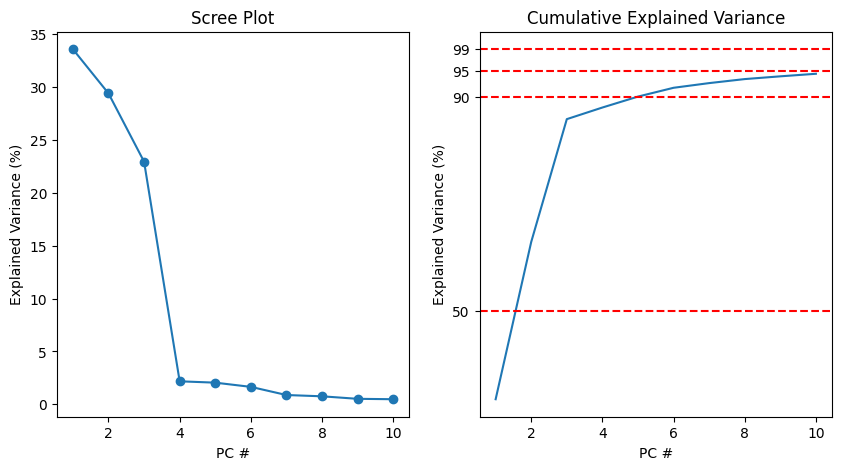

In [13]:
analysis_3BFF_RNN.plot_scree()

array([9.1709381e-01, 5.6701325e-02, 2.3376392e-02, 1.3619915e-03,
       1.0584078e-03, 2.8574030e-04, 6.9824659e-05, 3.6382440e-05,
       1.1161608e-05, 2.7660851e-06], dtype=float32)

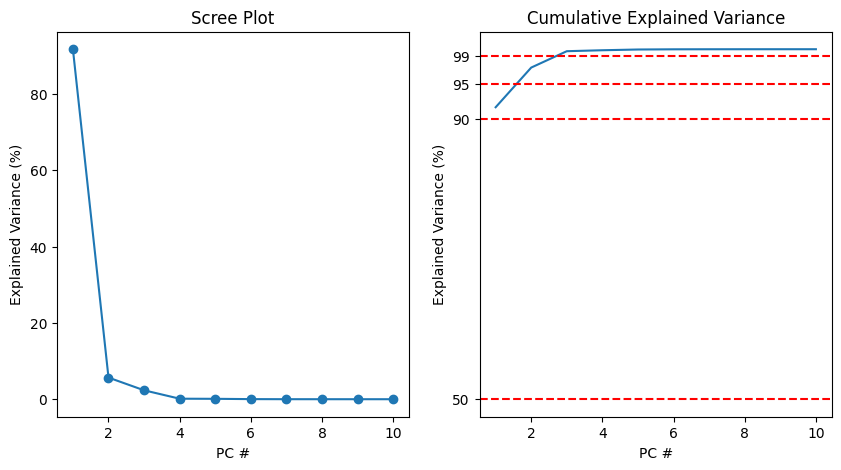

In [14]:
analysis_3BFF_NODE.plot_scree()

Importantly, the analysis object also provides functions that give access to the raw latent activity, predicted outputs, etc. of the trained models! All of these functions accept a "phase" variable that designates whether to return the training and/or validation datasets.
These functions are:
- `get_latents()`: Returns latent activity of the trained model
- `get_inputs()`: Returns the inputs to the model (for 3BFF, the input pulses)
- `get_model_output()`: Returns a dict that contains all model outputs:
  - controlled - the variable that the model is controlling
  - latents - the latent activity
  - actions - the output from the model (for RandomTarget only)
  - states - the state of the environment (for RandomTarget only)
  - joints - Joint angles (for RandomTarget only)

In [15]:
print(f"All data shape: {analysis_3BFF_RNN.get_latents().shape}")
print(f"Train data shape: {analysis_3BFF_RNN.get_latents(phase = 'train').shape}")
print(f"Validation data shape: {analysis_3BFF_RNN.get_latents(phase = 'val').shape}")

All data shape: torch.Size([1000, 500, 128])
Train data shape: torch.Size([800, 500, 128])
Validation data shape: torch.Size([200, 500, 128])


### Part 2: Using affine transformations to compare latent activity

Now that we have the latent activity for the 64D and the 128D GRU models trained on 3BFf, we can investigate how similar their latent activity is.

One problem: The models may be arbitrarily rotated, scaled, and translated relative to each other!

This means that we need to find the best "fit" between the two models that doesn't fail when they are equivalent under an "affine" transformation (meaning a linear transformation and/or translation).

Luckily, we have a tool that can solve this problem for us! Linear regression.

In this code, we are:

1. Getting the latent activity from each model
2. Performing PCA on the latent activity (to get the dimensions ordered by their variance)
3. Fit a linear regression from one set of latent activity to the other.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

source = analysis_3BFF_RNN
target = analysis_3BFF_NODE

# Get the latent activity from the validation phase for each model:
latents_source = source.get_latents(phase='train').detach().numpy()
latents_targ = target.get_latents(phase='train').detach().numpy()

latents_source_val = source.get_latents(phase='val').detach().numpy()
latents_targ_val = target.get_latents(phase='val').detach().numpy()

n_trials, n_timesteps, n_latent_source = latents_source.shape
n_trials, n_timesteps, n_latent_targ = latents_targ.shape

n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape
n_trials_val, n_timesteps_val, n_latent_targ_val = latents_targ_val.shape

print(f"Latent shape for source model: {latents_source.shape}"
      f"\nLatent shape for target model: {latents_targ.shape}")

Latent shape for source model: (800, 500, 128)
Latent shape for target model: (800, 500, 14)


In [17]:
# Perform PCA on both latent spaces to find axes of highest variance
pca_source = PCA()
pca_targ = PCA()
lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))

lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))

# Fit a linear regression model to predict the target latents from the source latents
reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
# Get the R2 of the fit
preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
print(f"R2 of linear regression fit: {r2s}")
print(f"Variance-weighted R2 of linear regression fit: {r2_var}")

R2 of linear regression fit: [ 1.1561555e-01  4.3450350e-01  4.7245443e-01  1.1622369e-02
  3.5038412e-02  1.2164235e-02  2.4754882e-02 -2.2754669e-03
  1.1004508e-02  2.5137663e-03 -6.6106319e-03 -3.4312010e-03
 -1.4270544e-03 -9.6321106e-05]
Variance-weighted R2 of linear regression fit: 0.14199790358543396


In [18]:
def compare_latent_pca(model1, model2):
    """
    Compare latent dynamics between two models using PCA and linear regression.

    Parameters:
    - model1: Analysis_TT object (source)
    - model2: Analysis_TT object (target)

    Returns:
    - r2s: array of R² scores per latent dim
    - r2_var: variance-weighted R² score
    """
    # Get latents from traning phase
    latents_source = model1.get_latents(phase='train').detach().numpy()
    latents_targ = model2.get_latents(phase='train').detach().numpy()

    # Get latents from validation phase
    latents_source_val = model1.get_latents(phase='val').detach().numpy()
    latents_targ_val = model2.get_latents(phase='val').detach().numpy()

    n_trials, n_timesteps, n_latent_source = latents_source.shape
    n_trials, n_timesteps, n_latent_targ = latents_targ.shape

    n_trials_val, n_timesteps_val, n_latent_source_val = latents_source_val.shape
    n_trials_val, n_timesteps_val, n_latent_targ_val = latents_targ_val.shape
        
    print(f"Latent shape for source model {model1.run_name}: {latents_source.shape}"
        f"\nLatent shape for target model {model2.run_name}: {latents_targ.shape}")
    
    # PCA
    pca_source = PCA()
    pca_targ = PCA()
    
    lats_source_pca = pca_source.fit_transform(latents_source.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))
    lats_source_pca_val = pca_source.transform(latents_source_val.reshape(-1, n_latent_source)).reshape((n_trials, n_timesteps, -1))

    lats_targ_pca = pca_targ.fit_transform(latents_targ.reshape(-1, n_latent_targ)).reshape((n_trials, n_timesteps, -1))
    lats_targ_pca_val = pca_targ.transform(latents_targ_val.reshape(-1, n_latent_targ_val)).reshape((n_trials_val, n_timesteps_val, -1))

    # Fit a linear regression model to predict the target latents from the source latents
    reg = LinearRegression().fit(lats_source_pca.reshape(-1, n_latent_source), lats_targ_pca.reshape(-1, n_latent_targ))
    # Get the R2 of the fit
    preds = reg.predict(lats_source_pca_val.reshape(-1, n_latent_source_val))
    r2s = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds,  multioutput = "raw_values")
    r2_var = r2_score(lats_targ_pca_val.reshape((-1, n_latent_targ_val)), preds, multioutput = "variance_weighted")
    print(f"R2 of linear regression fit: {r2s}")
    print(f"Variance-weighted R2 of linear regression fit: {r2_var}")

    return r2s, r2_var

In [19]:
comparison_3bff_3node = compare_latent_pca(analysis_4BFF_RNN, analysis_4BFF_NODE)

Latent shape for source model 4BFF-RNN: (800, 500, 128)
Latent shape for target model 4BFF-NODE: (800, 500, 29)
R2 of linear regression fit: [ 1.9377595e-01  8.4481263e-01  8.8796932e-01  8.5774004e-01
  8.6301613e-01  1.6594321e-01  7.4074864e-02  6.4718843e-02
  5.0838828e-02  1.1321783e-01  6.2771499e-02  9.7482920e-02
  3.4685850e-02  1.4229953e-02  1.6942680e-02  2.7052641e-02
  1.5943646e-03  1.6203880e-02  2.8395176e-02  5.7411194e-04
  1.7664433e-02 -5.1279068e-03  4.5235157e-03  4.8629045e-03
  2.6896298e-02  4.1792393e-03  1.4851093e-03  4.7515631e-03
  3.5675168e-03]
Variance-weighted R2 of linear regression fit: 0.6084316372871399


So, the variance weighted R2 from the source to the target is ~0.93.

Importantly, we had to pick a "direction" to compute this R2 value. What happens if we switch the source and targets?

❓❓❓

**Try reversing the direction (the source and targets) and see how well the model fits!**

❓❓❓

One final tool that is provided to you is the comparison object, which makes many of these direct comparisons within the object itself. Here is one example visualization that shows how similar the latent activities of two example trials are for these two models!

This function has the affine transformation "built-in," so you don't need this to show what your R2 value above looks like in the first 3 PCs!

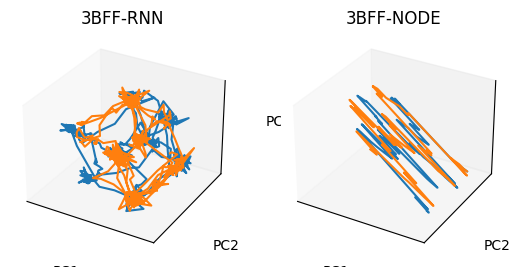

In [20]:
from ctd.comparison.comparison import Comparison
comp = Comparison()
comp.load_analysis(analysis_3BFF_RNN, reference_analysis=True)
comp.load_analysis(analysis_3BFF_NODE)
comp.plot_trials_3d_reference(num_trials=2)

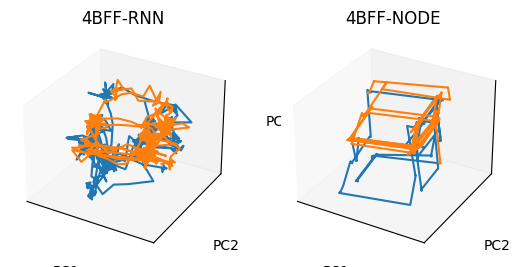

In [21]:
comp = Comparison()
comp.load_analysis(analysis_4BFF_RNN, reference_analysis=True)
comp.load_analysis(analysis_4BFF_NODE)
comp.plot_trials_3d_reference(num_trials=2)

### Part 3: Fixed-point finding

Finally, we can use fixed-point finding to inspect the linearized dynamics of the trained model.

**What are fixed-points?**

Fixed points are points in the dynamics for which the flow field is zero, meaning that points at that location do not move.

The fixed point structure for the 3BFF task was first shown in the original [Sussillo and Barack paper](https://ccn.johndmurray.org/ccn_2013/materials/pdf/mante/sussillo_2013.pdf).

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/SussilloBarack.png?raw=true" width="400"/>


We can see that the fixed-points are at the vertices of the cube above, drawing the activity towards them and keeping it there until an input pushes it out!

We use a modified version of a fixed point finder released by [Golub et al. 2018](https://github.com/mattgolub/fixed-point-finder) to search the flow field for these zero points.

❓❓❓

**Try changing some of these parameters:**
- How quickly are the fixed-points found in the model?
- How many initializations are needed to find the fixed points?
- Do the stability properties tell us anything about the underlying computation?

❓❓❓

Importantly from [Driscol et al. 2022](https://www.biorxiv.org/content/10.1101/2022.08.15.503870v1.full.pdf), we know that changes in the inputs can have large effects on the fixed point architecture, so we're going to set the inputs to zero in this optimization.

In [22]:
import torch
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    fps = analysis_GRU_128.plot_fps(
        inputs= torch.zeros(3),
        n_inits=1024,
        learning_rate=1e-3,
        noise_scale=0.0,
        max_iters=20000,
        seed=0,
        compute_jacobians=True,
        q_thresh=1e-5,
    )

NameError: name 'analysis_GRU_128' is not defined

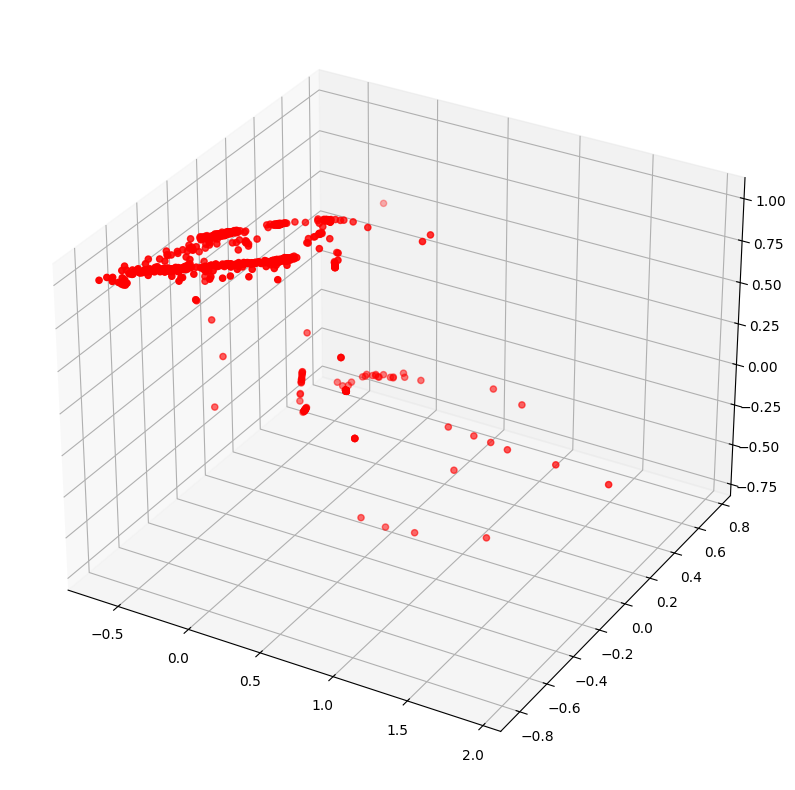

In [ ]:
import matplotlib.pyplot as plt
q_thesh = 1e-6
q_vals = fps.qstar
x_star = fps.xstar[q_vals < q_thesh]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_star[:, 0], x_star[:, 1], x_star[:, 2], c='r', marker='o')
fig.show()

❓❓❓

What can you find out about the FPs of the trained models? Can you modify the FP finding to get more interpretable results?

What can we learn about the computational solution built in this 3BFF network from these fixed-point architectures?

❓❓❓

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_fixed_point_finding")

## Section 6: Introducing the Random Target task

Now that we've developed intuition on a simple, well-understood task, let's move up the ladder of complexity!

The second task is a random-target reaching task performed by an RNN controlling a 2-joint musculoskeletal model of an arm actuated by 6 Mujoco muscles. This environment was built using MotorNet, a package developed by [Oli Codol et al.](https://github.com/OlivierCodol/MotorNet) that provides environments for training RNNs to control biomechanical models!

Here is a short clip of what this task looks like when performed by a well-trained model:

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/FinalGif.gif?raw=true" width="300"/>


Behaviorally, the task has the following structure:
1. A random initial hand position is sampled from a range of reachable locations; the model is instructed to maintain that hand position.
2. A random target position is chosen from the range of reachable locations and fed to the model.
3. After a random delay period, a go-cue is fed to the model, which prompts the model to generate muscle activations that drive the hand to the target location.
4. On 20% of trials, the go-cue is never supplied ("catch" trials)
5. On 50% of trials, a randomly directed bump perturbation (5-10 N, 150-300 ms duration) is applied to the hand.
    - 50% of these bumps occur in a small window after the go-cue
    - 50% of these bumps occur at a random time in the trial

The model is trained to:
1. Minimize the MSE between the hand position and the desired hand position
2. Minimize the squared muscle activation

with each loss term being weighted by a scalar.

In [ ]:
from ctd.task_modeling.task_env.task_env import RandomTarget
from motornet.effector import RigidTendonArm26
from motornet.muscle import MujocoHillMuscle
# Create the analysis object:
rt_task_env = RandomTarget(effector = RigidTendonArm26(muscle = MujocoHillMuscle()))

⏳⏳⏳

Now, to train the model! We use the same procedure as the 3BFF above; however, this model will take a bit longer to train, as of the serial nature of this task, the parallelization allowed by GPUs doesn't help speed up our training!

⏳⏳⏳

In [ ]:
from ctd.task_modeling.model.rnn import GRU_RNN
from ctd.task_modeling.datamodule.task_datamodule import TaskDataModule
from ctd.task_modeling.task_wrapper.task_wrapper import TaskTrainedWrapper
from pytorch_lightning import Trainer

# Step 1: Instantiate the model
rnn = GRU_RNN(latent_size = 128) # Look in ctd/task_modeling/models for alternative choices!

# Step 2: Instantiate the task environment
task_env = rt_task_env

# Step 3: Instantiate the task datamodule
task_datamodule = TaskDataModule(task_env, n_samples = 1000, batch_size = 256)

# Step 4: Instantiate the task wrapper
task_wrapper = TaskTrainedWrapper(learning_rate=1e-3, weight_decay = 1e-8)

# Step 5: Initialize the model with the input and output sizes
rnn.init_model(
    input_size = task_env.observation_space.shape[0] + task_env.context_inputs.shape[0],
    output_size = task_env.action_space.shape[0]
    )

# Step 6:  Set the environment and model in the task wrapper
task_wrapper.set_environment(task_env)
task_wrapper.set_model(rnn)

# Step 7: Define the PyTorch Lightning Trainer object (put `enable_progress_bar=True` to observe training progress)
trainer = Trainer(accelerator= "cpu",max_epochs=500,enable_progress_bar=False)

# Step 8: Fit the model
trainer.fit(task_wrapper, task_datamodule)

/opt/hostedtoolcache/Python/3.9.19/x64/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'data_env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['data_env'])`.
GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


/home/runner/work/NeuroAI_Course/NeuroAI_Course/ComputationThruDynamicsBenchmark/ctd/task_modeling/task_env/task_env.py:334: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(ang_targ, dtype=torch.float32, device=self.device)
/home/runner/work/NeuroAI_Course/NeuroAI_Course/ComputationThruDynamicsBenchmark/ctd/task_modeling/task_env/task_env.py:338: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(angs, dtype=torch.float32, device=self.device)



  | Name     | Type         | Params
------------------------------------------
0 | task_env | RandomTarget | 84    
1 | model    | GRU_RNN      | 57.4 K
------------------------------------------
57.4 K    Trainable params
84        Non-trainable params
57.4 K    Total params
0.230     Total estimated model params size (MB)


/opt/hostedtoolcache/Python/3.9.19/x64/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


`Trainer.fit` stopped: `max_epochs=500` reached.


Importantly, this task is distinct from the previous two tasks because the outputs of the model affect the subsequent inputs!

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/MotorNetIllustration-01.png?raw=true" width="400"/>


Visualizing the latent dynamics of models trained on MotorNet tasks, we can see that there are complex features in the state space, but we'll leave that to you to figure out what they mean!

<img src="https://github.com/neuromatch/NeuroAI_Course/blob/main/projects/project-notebooks/static/MotorNetGif.gif?raw=true" width="300"/>

In the later questions, we will ask you to modify the environments in MotorNet to test how well your models can generalize to new tasks!

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_introducing_the_random_target_task")

---
## Conclusion

That's it!

To recap, in this tutorial, we learned:
1. The basics of two tasks, the Three-Bit Flip-Flop and the Random Target task.
2. How to train recurrent neural network models on these tasks
3. Methods of visualizing and quantifying differences between these task-trained models.

As you begin to extend beyond this tutorial, you will likely need to make your own environments, or modify existing environments to test the ability of models to generalize. We've tried to document the code-base to make this as easy as possible, but feel free to reach out if you have any questions!

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_conclusion")